In [1]:
import pandas as pd  
import numpy as np  
import warnings
warnings.filterwarnings('ignore')

## Read the data

In [2]:
data = pd.read_excel('data_for_tree.xlsx')  

In [3]:
data.head()

,uid,oil_actv_dt,create_dt,total_oil_cnt,pay_amount_total,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
0,A8217710,2018-08-19,2018-08-17,275.0,48295495.4,B,0,3308.56,1760081.0,1796001.0,1731081.0,8655401.0,1.0,1.0,1,3,2,0,3
1,A8217710,2018-08-19,2018-08-16,275.0,48295495.4,B,0,4674.68,2487045.0,2537801.0,2437845.0,12189221.0,1.0,1.0,1,3,2,0,3
2,A8217710,2018-08-19,2018-08-15,275.0,48295495.4,B,0,1873.06,977845.0,997801.0,961845.0,4809221.0,1.0,1.0,1,2,2,0,3
3,A8217710,2018-08-19,2018-08-14,275.0,48295495.4,B,0,4837.78,2526441.0,2578001.0,2484441.0,12422201.0,1.0,1.0,1,2,2,0,3
4,A8217710,2018-08-19,2018-08-13,275.0,48295495.4,B,0,2586.38,1350441.0,1378001.0,1328441.0,6642201.0,1.0,1.0,1,2,2,0,3


## Feature engineering

### Feature classification

In [4]:
org_lst = ['uid','create_dt','oil_actv_dt','class_new','bad_ind']
# continuous features
agg_lst = ['oil_amount','discount_amount','sale_amount','amount','pay_amount','coupon_amount','payment_coupon_amount']
# discrete features
dstc_lst = ['channel_code','oil_code','scene','source_app','call_source']

In [5]:
df = data[org_lst].copy()
df[agg_lst] = data[agg_lst].copy()
df[dstc_lst] = data[dstc_lst].copy()
df.head()

,uid,create_dt,oil_actv_dt,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
0,A8217710,2018-08-17,2018-08-19,B,0,3308.56,1760081.0,1796001.0,1731081.0,8655401.0,1.0,1.0,1,3,2,0,3
1,A8217710,2018-08-16,2018-08-19,B,0,4674.68,2487045.0,2537801.0,2437845.0,12189221.0,1.0,1.0,1,3,2,0,3
2,A8217710,2018-08-15,2018-08-19,B,0,1873.06,977845.0,997801.0,961845.0,4809221.0,1.0,1.0,1,2,2,0,3
3,A8217710,2018-08-14,2018-08-19,B,0,4837.78,2526441.0,2578001.0,2484441.0,12422201.0,1.0,1.0,1,2,2,0,3
4,A8217710,2018-08-13,2018-08-19,B,0,2586.38,1350441.0,1378001.0,1328441.0,6642201.0,1.0,1.0,1,2,2,0,3


In [6]:
base = df[org_lst].copy()
# drop duplicates
base = base.drop_duplicates(['uid'],keep = 'first')

### Feature derivation for continuous variable

In [7]:
gn = pd.DataFrame()
for i in agg_lst:  
    #calculate the number 
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:len(df[i])).reset_index())  
    tp.columns = ['uid',i + '_cnt']  
    if gn.empty == True:  
        gn = tp  
    else:  
        gn = pd.merge(gn,tp,on = 'uid',how = 'left') 
    
    #calculate the number of feature which is greater than 0求历史特征值大于零的个数  
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.where(df[i]>0,1,0).sum()).reset_index())  
    tp.columns = ['uid',i + '_num']  
    if gn.empty == True:  
        gn = tp  
    else:  
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')  
        
    #sum the each feature  
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nansum(df[i])).reset_index())  
    tp.columns = ['uid',i + '_tot']  
    if gn.empty == True:  
        gn = tp  
    else:  
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')  
    
    #get the maximum number of each feature
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index())  
    tp.columns = ['uid',i + '_max']  
    if gn.empty == True:  
        gn = tp  
    else:  
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')  
    
    #get the minimum number of each feature
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index())  
    tp.columns = ['uid',i + '_min']  
    if gn.empty == True:  
        gn = tp  
    else:  
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')  
    
    # get the variance of each feature 
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index())  
    tp.columns = ['uid',i + '_var']  
    if gn.empty == True:  
        gn = tp  
    else:  
        gn = pd.merge(gn,tp,on = 'uid',how = 'left') 
    
    #get the range of each feature  
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmax(df[i])-np.nanmin(df[i]) ).reset_index())  
    tp.columns = ['uid',i + '_ran']  
    if gn.empty == True:  
        gn = tp  
    else:  
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')  
    
    
    #get the coefficient of variation (mean/vairation + 0.01 just in case variation get 0)
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df:np.nanmean(df[i])/(np.nanvar(df[i])+0.01))).reset_index()  
    tp.columns = ['uid',i + '_cva']  
    if gn.empty == True:  
        gn = tp  
    else:  
        gn = pd.merge(gn,tp,on = 'uid',how = 'left') 

### Feature derivation for discrete variable

In [8]:
gc = pd.DataFrame()  
for i in dstc_lst:  
    tp = pd.DataFrame(df.groupby('uid').apply(lambda df: len(set(df[i]))).reset_index())  
    tp.columns = ['uid',i + '_dstc']  
    if gc.empty == True:  
        gc = tp  
    else:  
        gc = pd.merge(gc,tp,on = 'uid',how = 'left')

### Aggregration of dataframe

In [9]:
fn = base.merge(gn,on='uid').merge(gc,on='uid')  
fn.shape

(11307, 66)

## Modeling - CART Regreesion Tree

In [10]:
from sklearn.tree import DecisionTreeRegressor
X = fn.drop(['uid','oil_actv_dt','create_dt','bad_ind','class_new'],axis = 1)
X.fillna(X.mean(), inplace=True)
y = fn.bad_ind.copy()

In [11]:
dtree = DecisionTreeRegressor(max_depth = 2,min_samples_leaf = 500,min_samples_split = 5000)  
dtree = dtree.fit(X,y) 

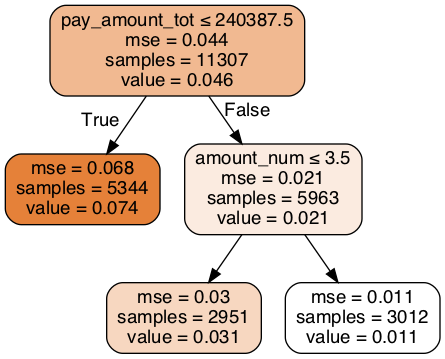

In [14]:
import pydotplus   
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
import os  
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,  
                         feature_names=X.columns,  
                         class_names=['bad_ind'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())   
Image(graph.create_png())  

## Labelling

In [13]:
dff1 = fn.loc[(fn.amount_tot>9614.5)&(fn.coupon_amount_cnt>6)].copy()  
dff1['level'] = 'past_A'  
dff2 = fn.loc[(fn.amount_tot>9614.5)&(fn.coupon_amount_cnt<=6)].copy()  
dff2['level'] = 'past_B'  
dff3 = fn.loc[fn.amount_tot<=9614.5].copy()  
dff3['level'] = 'past_C'